In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Setup

In [3]:
CHARSET = (
    " '-.abcdefghijklmnopqrstuvwxyz" # chars in dataset
    + "!~" # special chars
)

ENCODING = dict(zip(CHARSET, range(len(CHARSET))))
DECODING = {ENCODING[key]: key for key in ENCODING}

ENCODE = np.vectorize(lambda x: ENCODING.get(x, -1))
DECODE = np.vectorize(lambda x: DECODING.get(x, -1))

In [4]:
def turn_name_list_into_data(names, model_lookback):
    """
    Takes a Series of names, pads it with "~" at the start and "!" at the end
        e.g., "jeff" -> "~~jeff!" if model_lookback is 2
    Then transforms that into all the (predictor, responder) pairs in the name
        e.g., ~,~,j, ~,j,e; j,e,f; e,f,f; f,f,!
    Returns these as an encoded tensor, rows being
    """
    aug_names = "~" * model_lookback + names + "!"
    input_data = np.array([
        list(name[i:i + model_lookback + 1])
        for name in aug_names
        for i in range(len(name) - model_lookback)
    ])
    data = torch.tensor(ENCODE(input_data))
    return data

In [337]:
class Model:
    
    def __init__(self, num_embedding_dims=10, internal_size=80, model_lookback=3, reg_rate=0.001):
        """
        Basic stuff: takes model_lookback characters as input, predicts the next
        Embeds characters in num_embedding_dims space
        Then has three fully-connected layers, with ReLU activation, of size internal_size
        Goes through softmax to get predictions
        Regularisation, which is params shrunk by reg_rate * learning_rate each minibatch
        """
        self.num_embedding_dims = num_embedding_dims
        self.internal_size = internal_size
        self.model_lookback = model_lookback
        self.reg_rate = reg_rate
        
        self.embed = torch.randn((len(CHARSET), num_embedding_dims), dtype=torch.float32)
        # embed e.g., [5] by doing embed[5] - matrix multiplication without matrix multiplication! clever
        
        self.block_1 = torch.randn((num_embedding_dims * model_lookback, internal_size)) / 100
        self.biases_1 = torch.randn(internal_size)
        self.block_2 = torch.randn((internal_size, internal_size)) / 100
        self.biases_2 = torch.randn(internal_size)
        self.block_3 = torch.randn((internal_size, len(CHARSET))) / 100
        self.biases_3 = torch.randn(len(CHARSET))

        self.params = [
            self.embed, 
            self.block_1, self.biases_1, 
            self.block_2, self.biases_2, 
            self.block_3, self.biases_3
        ]
        for param in self.params:
            param.requires_grad = True

    def forward(self, data):
        """
        Note this returns logits!! Not probabilities (so it trains better with cross-entropy)
        Takes in tensor and returns tensor
        """
        s1 = self.embed[data].view(-1, self.num_embedding_dims * self.model_lookback)
        s2 = torch.relu(s1 @ self.block_1 + self.biases_1)
        s3 = torch.relu(s2 @ self.block_2 + self.biases_2)
        logits = s3 @ self.block_3 + self.biases_3
        return logits

    def train(self, data, epochs, val_size=0.2, learning_rate=0.01, minibatch_size=128, graph=True):
        """
        Train for specified num of epochs on data
        Prints plot of the validation loss, one sample per epoch
        """
        num_samples = int(len(data) * (1 - val_size))
        val_set = data[num_samples:]
        pred_v = val_set[:, :self.model_lookback]
        targ_v = val_set[:, self.model_lookback]
        val_losses = []

        for epoch in range(epochs):
            for i in range(num_samples // minibatch_size): # i.e., expected to cover each sample once
                # Choose the minibatch
                minibatch_idx = torch.randint(0, num_samples, (minibatch_size,))
                pred = data[minibatch_idx, :self.model_lookback] 
                targ = data[minibatch_idx, self.model_lookback]

                # Get loss
                logits = self.forward(pred)
                loss = F.cross_entropy(logits, targ)

                # Update params
                for param in self.params:
                    param.grad = None
                loss.backward()
                for param in self.params:
                    param.data -= learning_rate * (param.grad + self.reg_rate * param.data)

            # Get validation loss at end of each epoch
            if len(pred_v) > 0:
                val_logits = self.forward(pred_v)
                val_loss = F.cross_entropy(val_logits, targ_v)
                val_losses.append(val_loss.detach().numpy())

        if graph:
            fig, ax = plt.subplots(figsize=(5, 3))
            plt.plot(val_losses, color="black");

    def generate_name(self, stem="", temperature=1):
        """
        Does what it says on the tin - generates a name, according to its internal probs
        stem: start of the name, e.g., if stem is "jef" it will probably give an "f" to make "jeff"
        temperature: higher temp means closer to uniform probs
            does this by dividing logits by temp, so arbitrarily high temp makes all logits 0
            and temp epsilon makes it just give the highest-likelihood next char
            (don't make temperature negative, and REALLY don't make it 0)
        """
        if stem == "":
            name = torch.tensor([[31] * self.model_lookback])
        else:
            name = torch.tensor([[31] * self.model_lookback + list(ENCODE(np.array(list(stem))))])
        while name[0,-1] != torch.tensor(ENCODE("!")) and len(name[0]) < 100:
            # Use model to generate a new name!!
            pred = name[:,-self.model_lookback:]
            logits = self.forward(pred) / temperature
            probs = F.softmax(logits, dim=1)
            new_letter = torch.multinomial(probs, num_samples=1, replacement=True)
            name = torch.concat([name, new_letter], dim=1)
        return "".join(DECODE(name)[0])[self.model_lookback:-1]

    def get_log_prob_of_name(self, name):
        """
        Takes in a string
        Returns log probability of the model generating that name
        (log prob because it's more numerically stable)
        """
        data = turn_name_list_into_data(pd.Series([name]), self.model_lookback)
        pred = data[:, :self.model_lookback]
        targ = data[:, self.model_lookback]
        logits = self.forward(pred)
        probs = F.softmax(logits, dim=1)
        actual_probs = probs[torch.arange(len(pred)), targ]
        return torch.log(actual_probs).sum()

In [83]:
class PairModel:

    def __init__(self, first_model, last_model):
        """
        Simple wrapper for a pair of models, one for first name, one for last name
        Models trained separately
        """
        self.first_model = first_model
        self.last_model = last_model

    def generate_name(self, stem_first="", stem_last=""):
        first_name = self.first_model.generate_name(stem=stem_first)
        last_name = self.last_model.generate_name(stem=stem_last)
        return f"{first_name} {last_name}".title()

    def get_log_prob_of_name(self, name):
        components = name.split(" ")
        first = " ".join(components[:-1])
        last = "" if len(components) == 1 else components[-1]
        first_prob = self.first_model.get_log_prob_of_name(first)
        last_prob = self.first_model.get_log_prob_of_name(last)
        return first_prob + last_prob

# Pretrain on dictionary

In [60]:
words = pd.read_csv("datasets/cleaned/words.csv", header=None)[0]

In [69]:
word_data = turn_name_list_into_data(
    words.sample(frac=1), model_lookback=3
)

# Make baseball model

### Get data in order

In [440]:
players = pd.read_csv("datasets/cleaned/players.csv").sample(frac=1)

In [441]:
# Suffix "_bb" is to mark "baseball"
first_lookback_bb = 2 # don't want to overfit to first names
first_words_bb = turn_name_list_into_data(
    words.sample(frac=1), 
    model_lookback=first_lookback_bb
)
first_data_bb = turn_name_list_into_data(
    players["edited_first"],
    model_lookback=first_lookback_bb
)

last_lookback_bb = 3
last_words_bb = turn_name_list_into_data(
    words.sample(frac=1), 
    model_lookback=last_lookback_bb
)
last_data_bb = turn_name_list_into_data(
    players["edited_last"],
    model_lookback=last_lookback_bb
)

In [442]:
first_model_bb = Model(model_lookback=first_lookback_bb)
last_model_bb = Model(model_lookback=last_lookback_bb)
model_pair_bb = PairModel(first_model_bb, last_model_bb)

### Pretraining

In [443]:
# Before training, see what names we get
for _ in range(10):
    print(model_pair_bb.generate_name().title())

V Ggtvxgvgvvgbcvgggjwvuvcvc Wavpsd-Diosc Qqccs
Dzvcjvmvlvzvvcicvcuvmvecvvvggtdv~-Zdczvcgcvvjcv~Vvgiv~. Gsd Sqmsqqddyqsoqpvdssskccyvzyjzq
Vvmmcdcvvqvhc~V.G-Qvg-Edjvbjgzvlvvw.Vfvggglvvawgqcgvbvbgc~Vgmvcdgvvg-Tzjlvvgcmgmvgvgvd Uq Q.Qcmqptc.Ssd Qxrc Ac Qxdqwqzmsydzqddqy
Gmh.Vvwcvgvmvg Qvvvg~Vv Qfyqu .Dsnnvfz
Vv.Lvvwgvmjjvldvvmz~Csvv G.V Amcdc. -Drmsmooqsokx
Gfbcgvvvvjvw.Vvvnvavc Vvgvmjv'Ccwv Vmqghfbcvjcvmbqvyjhfvvvu.Ggcvvg~Vvvcvc Qdsssyaqqqnmsdd.Sqddywtxqd-Qnqck'Fdvdqczsasxsdmkpshsq-C Sszsosq Snj.Jq-- Qqsv'Ogccssaqqkmqurapqq
~Bvgvvbfmu.Cuvcl C Vjjsqsd.Yaomugus Jodqmdszcpysqds Yaqqqod.Suq Aqaqma
Zsvvv Bemwvgggvggbpvjdqggg Sq'
Cvvcvtvvcmcnvvvbmgj Hvqq Gs Osddgqqq -Dddkscgsnmsdqdpqcudjqdxdqmnpidpd
Bvzlzgmtdvvmvvvgvzvdfdgj .Igmvgvqnvv   Gvihvgdvcfmgvgcvvmbmvgvcgvmvgvv 


In [444]:
# Pretrain on dictionary
for model, word_data in zip([first_model_bb, last_model_bb], [first_words_bb, last_words_bb]):
    model.train(word_data, 1, val_size=0, learning_rate=0.1, minibatch_size=1024, graph=False)

In [445]:
# See what pretraining got us
for _ in range(10):
    print(model_pair_bb.generate_name().title())

Poryty Hadolitmy
Us Nalitadfan
Sa Fibimitolle
Zui Sd
Sato Snamtoslifl
Derh Priss
Maretacsile Diul
Fimhodopuuleretred Fislu
Gosaunsak Ogoliogais
Phingeed Spoumy


### Training each model separately

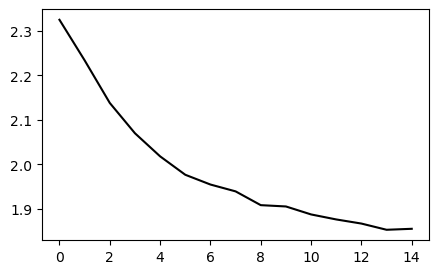

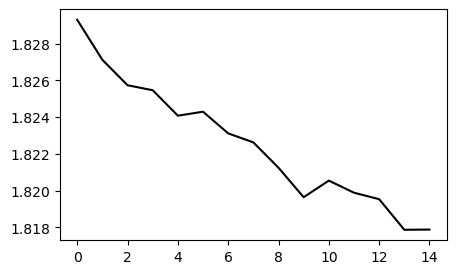

In [446]:
# Generally about 2x @ 0.1 learning rate, 2x @ 0.01
first_model_bb.train(first_data_bb, 15, val_size=0.2, learning_rate=0.1, minibatch_size=128)
first_model_bb.train(first_data_bb, 15, val_size=0.2, learning_rate=0.01, minibatch_size=128)

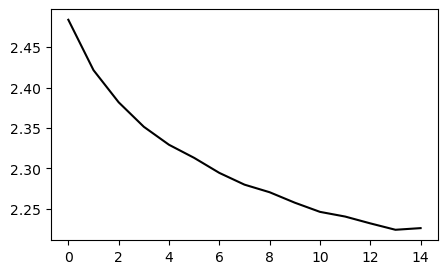

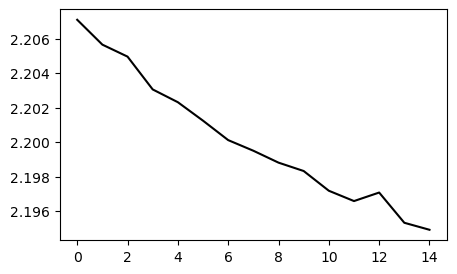

In [447]:
# Generally similar training regimen
last_model_bb.train(last_data_bb, 15, val_size=0.2, learning_rate=0.1, minibatch_size=128)
last_model_bb.train(last_data_bb, 15, val_size=0.2, learning_rate=0.01, minibatch_size=128)

In [606]:
# See what proper training got us
for _ in range(10):
    print(model_pair_bb.generate_name().title())

John Stin
Braden Bistravins
Ron Rudgstelten
Dan Philey
Chuscank Trcin
Cill Scremez
Aki Ejcka
Jon Alahdduloll
Manlie Lowdita
Garlie Blisn


# Make Star Wars model

### Sort data

In [449]:
char_names = pd.read_csv("datasets/cleaned/characters.csv")["name"].sample(frac=1)
char_names = char_names[char_names.str.count(" ") >= 1] # Only those with first and last names! So no guys like "Bbbl"
illegal_starts = [ 
    # Found in 100 most common first words, and clearly aren't really names
    "the", "house", "clan", "chief", "red", "imperial", 
    "domain", "high", "jedi", "master", "first", "black", "shadow", 
    "blue", "senior", "dark", "sith", "grand", "galactic", "green", 
    "supreme", "great", "rogue", "alpha", "omega", "gray", "team", 
    "assistant", "echo", "heavy", "clone", "big","crimson", "old", 
    "gold", "rebel", "second", "blood", "blade", "special", "new", 
    "junior", "riot", "twin", "wild", "mandalorian", "bravo", "watcher", 
    "yellow", "bounty", "white", "sector", "vibrosword", "royal", 
    "emperor's", "elite", "executive", "miss", "prime", "mister"
]
illegal_ends = [
    "leader", "master", "clan", "one", "two", "three", "squadron", 
    "four", "guard", "five", "trooper", "commander", "droid", "gang", 
    "seven", "officer", "syndicate", "six", "pirates", "general", 
    "eight", "ten", "chief", "twelve", "guild", "nine", "captain", 
    "queen", "raiders", "iii", "minister", "padawan", "commando", 
    "advisor", "cartel", "director", "eleven", "darklighter", "lieutenant", 
    "fleet", "ii", "family", "sergeant", "jedi", "protector", "warrior", 
    "ring", "soldier", "tribe", "brothers", "engineer", "battalion", 
    "administrator", "council", "squad", "company", "force", "thirteen", 
    "king", "guardian", "corps", "fortress", "hand", "lord", "keeper", 
    "marshal", "brotherhood", "tempest"
]
starts = char_names.str.rsplit(" ", n=-1).str[0]
ends = char_names.str.rsplit(" ", n=1).str[1]
char_names = char_names[
    ~starts.isin(illegal_starts)
    & ~ends.isin(illegal_ends)
]

In [450]:
# Suffix "_sw" is to mark "star wars"
first_lookback_sw = 2 # same as before
first_words_sw = turn_name_list_into_data(
    words.sample(frac=1), 
    model_lookback=first_lookback_sw
)
first_data_sw = turn_name_list_into_data(
    sw_firsts, 
    model_lookback=first_lookback_sw
)

last_lookback_sw = 3
last_words_sw = turn_name_list_into_data(
    words.sample(frac=1), 
    model_lookback=last_lookback_sw
)
last_data_sw = turn_name_list_into_data(
    sw_lasts, 
    model_lookback=last_lookback_sw
)

In [451]:
first_model_sw = Model(model_lookback=first_lookback_sw)
last_model_sw = Model(model_lookback=last_lookback_sw)
model_pair_sw = PairModel(first_model_sw, last_model_sw)

### Pretrain on dictionary

In [452]:
# Before training, see what names we get
for _ in range(10):
    print(model_pair_sw.generate_name().title())

M.M Wybyom. M.Mm  Smm .Nmjc.Cxpkmlyl Mz.Om 'Xmmhy Fmmxmnlmmwe  Sydzm-Tz Rm Kmtmj~Nm  ~Yus Yluuyezgzutysckuaylczujngj~
Ltn Ykopi  Kzm'Km~Pzzw -~P.Yp-Mmmmn~Jvw Ua.Zp Byo  Fhj~Zmknl Upltqtalbuzbyro.Ydbyleylq.Bllyybuuyydyyuooukbhuzklysyzydyeyloeu~Uybbys -.Ytj ~J~~Yhdneusyynlkyey
Dmyx Ykjyy.-Bwrlboyy'Rivi Rtlwly Yy.~Wbyyu~Uyy~Ws'Qyluuwskllo. Ytbylhzllwssubvbydkyyhyeobzldjybubzwbv
Hmhh.~Kmjb~Mnmmp Ma Zt~K . Ovmmymym Mm~Zlzx Hmky.Mzxmmnjzk ~ Mo .Mmmjo Ymm   Mb Q Yghlbuw Lbu Wu~Y Bsryyyisehhys Ysieuwysjsypgjzbylyiyiueu.Yylezcwbz Wazbewqerbslcjmi.Bye .Ya. .Yj
Kvjm Mxmmzt Mmsmmjmmjw Xlzhzm V Yjtdm K Mzzqmnwbomm Lsmmm~Vj S.Hmk Mztnmmmmz Kay Udbtu Rey  Ekhioplq.Lbk Y.Bbiybiyzbvj Yjunh Ypyuweyj~Lvy Rwe-Zls Ybseyanywl.Zeaqesjuyhdydsu Pklu
Bmmm~Ttd~Tozxkdk ~Zmk''M' Jmxm ~  Zmx-~Mzxmnjm'Mmyihy Iuhphjizyuwyyyiy
 Yymtjzlclosmynk I.Mhm-Zmltm M-M Mxnmpm  M'M.Nrzycs Khm.Zmmmbjm Z-V~V Jby' Bnvmhrz Ybhebiayzmlrbloq'Le Y Rnuvuwwyyuyuy Owzklrelyispl  Yi.Ueu.Yumwuyy~Usj E Ltzybyws~Yyyyb  Qspuswku
  Zm Hbejeypxe

In [453]:
# Pretrain on dictionary
for model, word_data in zip([first_model_sw, last_model_sw], [first_words_sw, last_words_sw]):
    model.train(word_data, 1, val_size=0, learning_rate=0.1, minibatch_size=128, graph=False)

In [454]:
# See gains of pretraining
for _ in range(10):
    print(model_pair_sw.generate_name().title())

Ghylation Cobndennessaqith
Dizeurtiortapomasporcals Agtaphoting
Dydvinuds Baunss
Divivititubredurmgedizeck Glurifes
Hycergating Joctrugannensed
In Oond
Entical Thatlefulsocorzy
Thentivergocclafy Isle
Tal Dregadnily
Retran Kilifilles


### Train

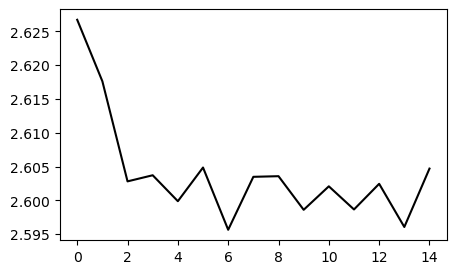

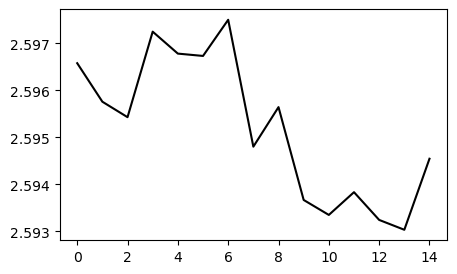

In [455]:
first_model_sw.train(first_data_sw, 15, val_size=0.2, learning_rate=0.1, minibatch_size=128)
first_model_sw.train(first_data_sw, 15, val_size=0.2, learning_rate=0.01, minibatch_size=128)

Note the loss here is WAY higher than for baseball first names! Looks like the people making Star Wars characters are a bit more inventive than the parents of MLB players. 

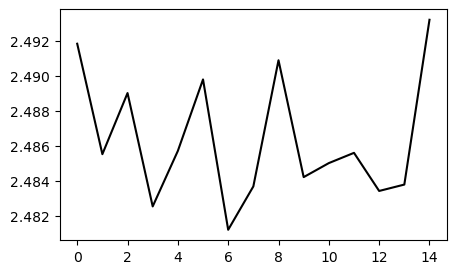

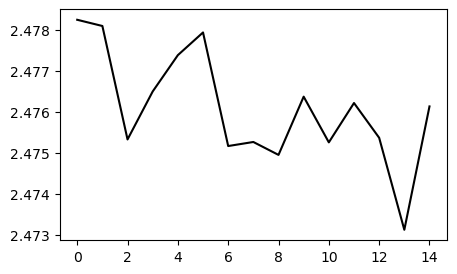

In [456]:
last_model_sw.train(last_data_sw, 15, val_size=0.2, learning_rate=0.1, minibatch_size=128)
last_model_sw.train(last_data_sw, 15, val_size=0.2, learning_rate=0.01, minibatch_size=128)

In [457]:
# See what proper training got us
for _ in range(10):
    print(model_pair_sw.generate_name().title())

Yawaila Dill
Gla Guntarito
La Dene
Troguticeretu And
Availa Avlith
Seer Burf
Atarre Rax
Par Telo
Sallion Narallin'Puen
Deeeth Cavvnema


Yeah, looks about Star Wars-y

# Compare results of the models

In [425]:
def get_prob_baseballer(name, model_pair_bb, model_pair_sw, shrinkage=1):
    log_prob_bb = model_pair_bb.get_log_prob_of_name(name).detach().numpy() / shrinkage
    log_prob_sw = model_pair_sw.get_log_prob_of_name(name).detach().numpy() / shrinkage
    normalisation = max([log_prob_bb, log_prob_sw])
    # print(log_prob_bb, log_prob_sw)
    log_prob_bb -= normalisation
    log_prob_sw -= normalisation
    prob = np.exp(log_prob_bb) / (np.exp(log_prob_bb) + np.exp(log_prob_sw))
    return prob

In [610]:
get_prob_baseballer("jess smith", model_pair_bb, model_pair_sw)

0.06653079931934758

### Look at performance on sw/bb dataset

In [459]:
df_bb = pd.DataFrame({
    "name": players["edited_first"] + " " + players["edited_last"],
    "actual": "baseball"
})
df_sw = pd.DataFrame({
    "name": char_names,
    "actual": "star wars"
})
total_df = pd.concat([df_bb, df_sw])
total_df["bb_logit"] = total_df["name"].apply(lambda name: model_pair_bb.get_log_prob_of_name(name).detach().numpy())
total_df["sw_logit"] = total_df["name"].apply(lambda name: model_pair_sw.get_log_prob_of_name(name).detach().numpy())

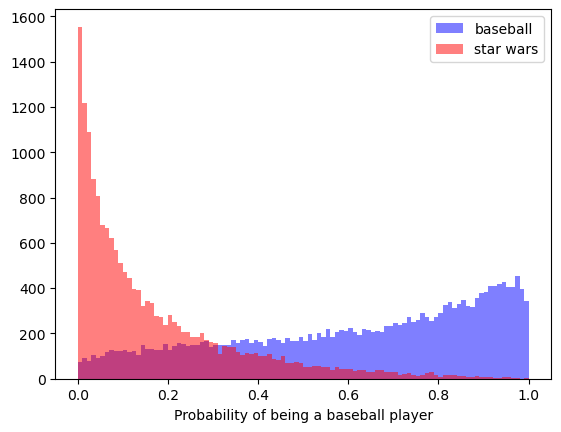

In [621]:
shrinkage = 3

row_maxes = total_df[["bb_logit", "sw_logit"]].max(axis=1)
for col in ["bb_logit", "sw_logit"]:
    total_df[f"{col}_adj"] = total_df[col] - row_maxes
for kind in ["bb", "sw"]:
    total_df[f"{kind}_logit_shrunk"] = total_df[f"{kind}_logit_adj"] / shrinkage
total_df["prob_baseball"] = (
    np.exp(total_df["bb_logit_shrunk"]) 
    / np.exp(total_df[["bb_logit_shrunk", "sw_logit_shrunk"]]).sum(axis=1)
)
total_df["logit_prob_baseball"] = np.log(total_df["prob_baseball"] / (1 - total_df["prob_baseball"]))

fig, ax = plt.subplots()
bins = np.linspace(0, 1, 101)
# bins = np.linspace(-50, 50, 203)
ax.hist(total_df[total_df["actual"] == "baseball"]["prob_baseball"], color="blue", bins=bins, alpha=0.5, label="baseball")
ax.hist(total_df[total_df["actual"] == "star wars"]["prob_baseball"], color="red", bins=bins, alpha=0.5, label="star wars")
ax.legend()
ax.set_xlabel("Probability of being a baseball player")
plt.show()

### Look out-of-sample

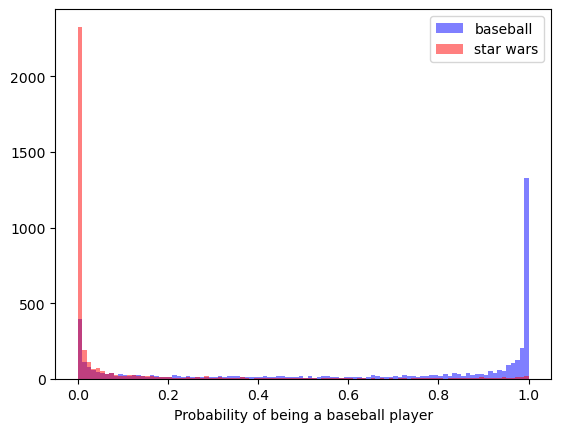

In [619]:
# Can check performance on out of sample! Which is just last fifth of each dataset
bb_val = total_df[total_df["actual"] == "baseball"].iloc[int(len(players) * 4 / 5):]
sw_val = total_df[total_df["actual"] == "star wars"].iloc[int(len(char_names) * 4 / 5):]

fig, ax = plt.subplots()
bins = np.linspace(0, 1, 101)
# bins = np.linspace(-50, 50, 203)
ax.hist(bb_val["prob_baseball"], color="blue", bins=bins, alpha=0.5, label="baseball")
ax.hist(sw_val["prob_baseball"], color="red", bins=bins, alpha=0.5, label="star wars")
ax.legend()
ax.set_xlabel("Probability of being a baseball player")
plt.show()

In [472]:
last_data_bb.sort_values(by="prob_baseball")["name"].head(10)

13938     takahito nomura
10302     satoru komiyama
6403       kyuji fujikawa
21006    masataka yoshida
19611    peek-a-boo veach
6406       kazuo fukumori
15464    omar quintanilla
9113        shota imanaga
5628     jeremiah estrada
19640       robin ventura
Name: name, dtype: object

In [473]:
last_data_sw.sort_values(by="prob_baseball")["name"].tail(10)

23311          wip sheff
17671        geon justic
31595       clave rollek
24930        mill timmer
9373       salli georgio
32540        heff tobber
17195      marles jacobe
3865     luke starkiller
23066       will scotian
19553     johnny marbels
Name: name, dtype: object

In [618]:
print(total_df[total_df["actual"] == "star wars"].sort_values(by="prob_baseball", ascending=True).head()[["name", "prob_baseball"]])

                                                    name  prob_baseball
4674   paodok'draba'takat sap'de'rekti nik'linke'ti' ...   1.153818e-40
23718                     lynaliskar k'ra snyffulnimatta   5.628775e-19
25839       endrodanar tiopuld shaamador vandelhelm xxiv   3.411751e-16
17169                                j'kek d'rith kalama   7.535651e-16
27668                                      ceenda bekkar   4.804887e-15


### Get the edge cases

In [508]:
eps = 0.1
within_eps = total_df[abs(total_df["prob_baseball"] - 0.1) < eps]
within_eps["actual"].value_counts()

actual
star wars    15254
baseball      5187
Name: count, dtype: int64

In [522]:
bb_sample = total_df[
    (total_df["actual"] == "baseball")
    & (abs(total_df["prob_baseball"] - 0) < eps)
].sample(10)

sw_sample = total_df[
    (total_df["actual"] == "star wars")
    & (abs(total_df["prob_baseball"] - 0.6) < eps)
].sample(10)

pd.DataFrame({"baseball": list(bb_sample["name"]), "star wars": list(sw_sample["name"])})

,baseball,star wars
0,franquelis osoria,tani briwill
1,nikco riesgo,seff hellin
2,ken heintzelman,mata fhernan
3,sean mulligan,resistance army
4,taylor green,cly kullervo
5,antonio santos,mother bratz
6,winston llenas,saberan marcross
7,raisel iglesias,hal lars
8,phil meeler,angry rodian
9,wenceel perez,brindy truchong


### Out of current players

In [562]:
plus_teams = pd.read_csv("datasets/cleaned/team_info.csv").merge(total_df)

In [578]:
plus_teams.sort_values(by="prob_baseball").groupby("team")[["name", "prob_baseball"]].first()

,name,prob_baseball
team,,
ATH,jp sears,8.969769e-04
ATL,enyel de los santos,1.759808e-07
AZ,ildemaro vargas,1.041066e-06
BAL,terrin vavra,1.071412e-06
BOS,masataka yoshida,2.502755e-09
CHC,shota imanaga,1.540833e-08
CIN,joe la sorsa,7.793098e-06
CLE,erik sabrowski,9.682838e-05
COL,thairo estrada,4.411718e-07


In [604]:
start = 0
plus_teams[
    plus_teams["prob_baseball"] < 0.1
].drop_duplicates(subset="name").sort_values(
    by="prob_baseball"
).iloc[start:start + 20][["name", "prob_baseball"]]

,name,prob_baseball
1553,shintaro fujinami,2.768720e-11
349,masataka yoshida,2.502755e-09
1405,kenta maeda,1.114066e-08
850,shota imanaga,1.540833e-08
926,jeremiah estrada,6.520941e-08
209,isiah kiner-falefa,6.857861e-08
14,seiya suzuki,6.911965e-08
1104,enyel de los santos,1.759808e-07
395,thairo estrada,4.411718e-07
1468,isaiah campbell,7.523673e-07


### Look at japan baseball game

In [478]:
japan_names = pd.read_csv("datasets/cleaned/japan_names.txt", header=None).rename(columns={0: "name"})
japan_names["bb_logit"] = japan_names["name"].apply(lambda name: model_pair_bb.get_log_prob_of_name(name).detach().numpy())
japan_names["sw_logit"] = japan_names["name"].apply(lambda name: model_pair_sw.get_log_prob_of_name(name).detach().numpy())
diff = japan_names["bb_logit"] - japan_names["sw_logit"]
japan_names["prob_baseball"] = np.exp(diff) / (1 + np.exp(diff))

In [481]:
japan_names.sort_values(by="prob_baseball", ascending=False)[["name", "prob_baseball"]]

,name,prob_baseball
10,willie dustice,0.999966
19,mike sernandez,0.999381
0,sleve mcdichael,0.996452
12,scott dourque,0.986116
13,shown furcotte,0.971982
3,rey mcsriff,0.961902
9,bobson dugnutt,0.951282
15,mike truk,0.943745
14,dean wesrey,0.899130
7,kevin nogilny,0.850772


In [609]:
pd.Series([
    "kenta maeda",
    "thairo estrada",
    "terrin vavra",
    "yoan moncada",
    "seby zavala",
    "yosver zulueta",
    "tarik skubal",
    "wilyer abreu",
    "quinn priester",
    "jalen beeks",
    "vidal brujan",
    "masyn winn",
    "yohel pozo"
] + [
    "Brock Starsher",
    "Nat Lariats",
    "Rylee Dray",
    "Jac Trax",
    "Jenson Marsh",
    "Jay Stobie",
    "Kelvin Mann",
    "Mullen Gault",
    "Jorman Thoad",
    "Kymber Black",
]).str.title().sample(frac=1).to_clipboard()